In [1]:
import pandas as pd
from datetime import datetime
import numpy as  np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import requests
from io import BytesIO

In [2]:
data = pd.read_csv('./datasets/WWWUsage.csv', index_col = 'time')
data.drop('Unnamed: 0', axis = 1, inplace = True)
data

,WWWusage
time,
1,88
2,84
3,85
4,85
5,84
...,...
96,222
97,228
98,226


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


train, test = train_test_split(data,
                               train_size = 0.8, shuffle = False)

scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns = ['train'])

<AxesSubplot: xlabel='time'>

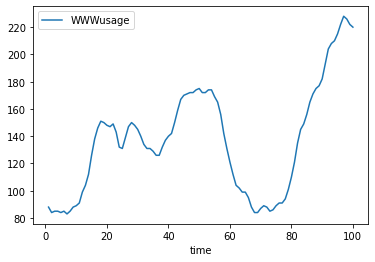

In [4]:

data.plot()

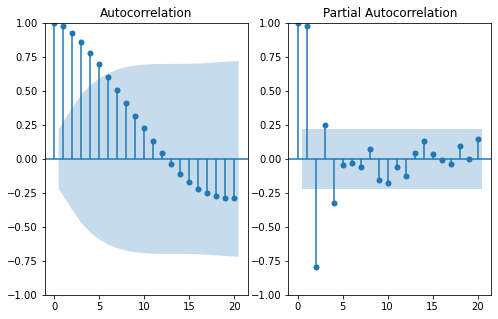

In [5]:
# Escoger parámetros de ARIMA

# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(train, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(train, ax=ax2, method='ols')

plt.show()

In [6]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [7]:
adf_test(train)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


In [8]:
diff1_values = train.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = train.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)


ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


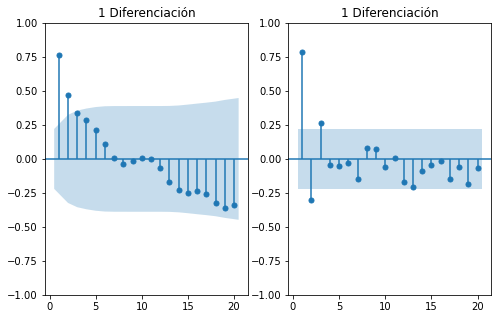

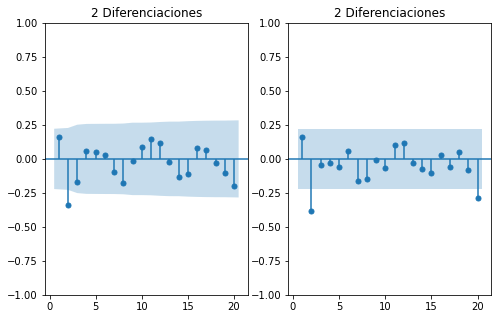

In [9]:
# 1. Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(diff1_values, {'lags':20, 'title': '1 Diferenciación'})

plot_acf_pacf(diff2_values, {'lags' : 20, 'title': '2 Diferenciaciones'})

## Valores pdq propuestos:

### Con una diferenciación
* p: 3
* d: 1
* q: 2


### Con dos diferenciaciones

* p: 2
* d: 2
* q: 2

In [10]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
# 1. Modelo de diferencia de primer orden
arima_model1 = ARIMA(train, order=(3, 1, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                  train   No. Observations:                   80
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 155.393
Date:                Tue, 07 Feb 2023   AIC                           -298.787
Time:                        16:42:51   BIC                           -284.570
Sample:                             0   HQIC                          -293.091
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0043      0.320      0.014      0.989      -0.623       0.632
ar.L2          0.0260      0.265      0.098      0.922      -0.494       0.546
ar.L3          0.3039      0.208      1.464      0.1

C:\Users\omara\anaconda3\envs\py3913\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# 2. Modelo de diferencia de segundo orden

# Basado en lo discutido anteriormente, necesitamos sólo considerar algunos términos AR y MA.
# Para ello definimos sus coeficientos cómo la especificación de polinomios

# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model2 = ARIMA(train, order=(ar, 2, ma))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  train   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                 147.782
Date:                Tue, 07 Feb 2023   AIC                           -289.563
Time:                        16:42:51   BIC                           -282.493
Sample:                             0   HQIC                          -286.733
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1582      0.299     -0.529      0.597      -0.744       0.428
ma.L2         -0.2137      0.299     -0.715      0.474      -0.799       0.372
sigma2         0.0013      0.000      5.533      0.0

### Elección de modelo


Para efectos de esta prueba, eligiremos el modelo 2 ya que tiene mayor log-likelihood y los valores de AIC, BIC son similares.

<AxesSubplot: xlabel='time'>

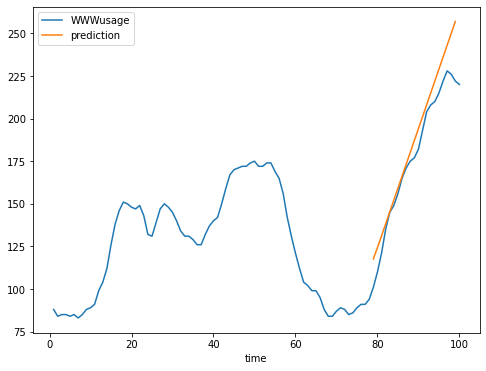

In [13]:
# Cómo realizar predicciones con el modelo ajustado
y_h = pd.DataFrame(scaler.inverse_transform(model2.predict(start = 80, 
                                                           end = 100, dynamic=False).to_frame()),
                   index = range(79,100),
                  columns = ['prediction'])

ax = data.plot(figsize = (8,6))

y_h.plot(ax=ax)

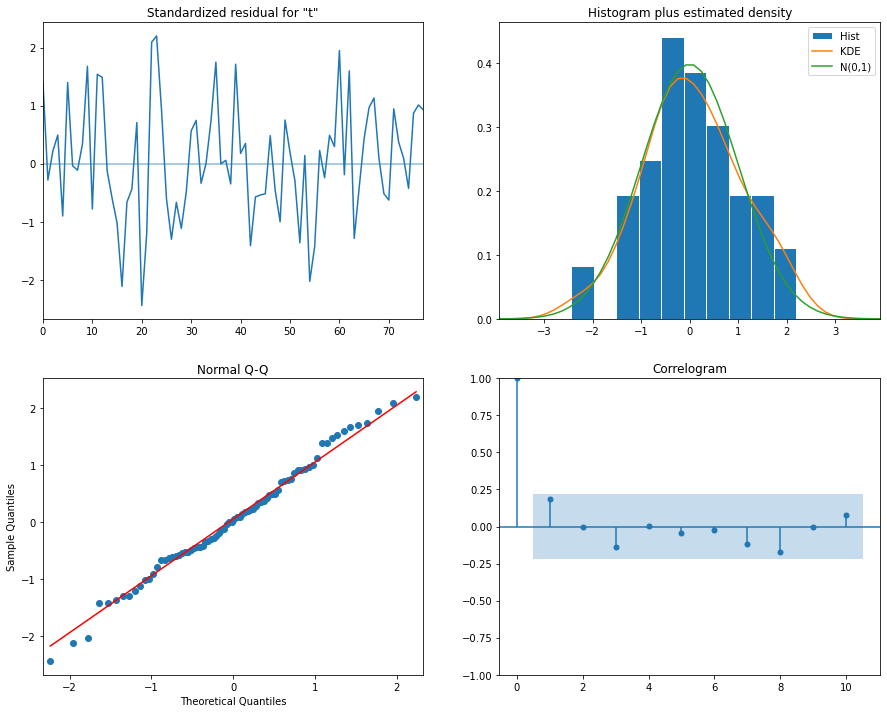

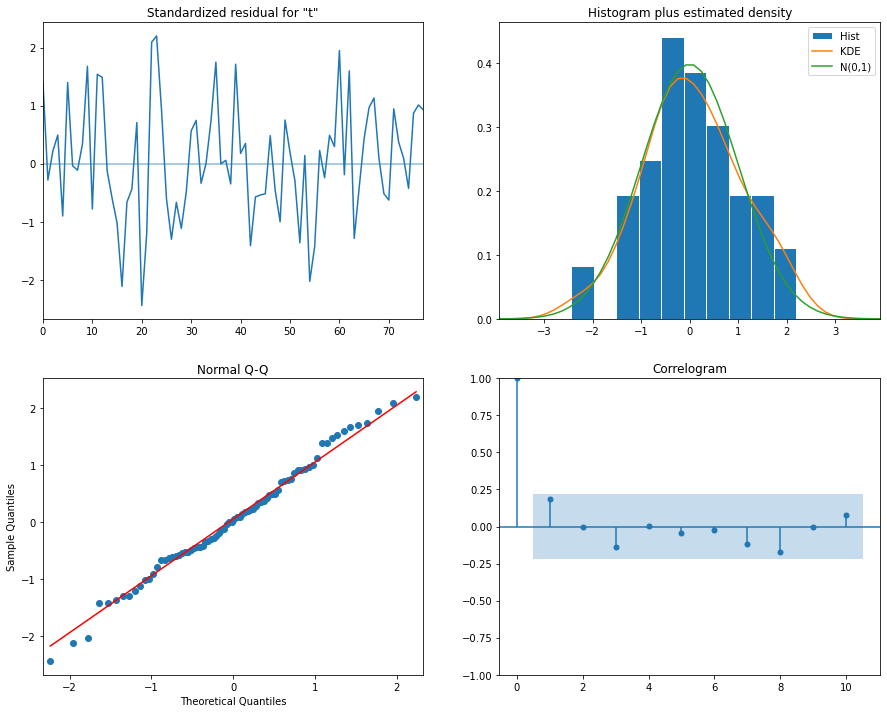

In [14]:
# Gráfico de los diagnósticos para los residuos
model2.plot_diagnostics(figsize = (15,12))

# Segunda parte

In [15]:
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')

C:\Users\omara\AppData\Local\Temp\ipykernel_16708\3584435750.py:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')


In [16]:
data2.drop(['time', 't'], axis = 1, inplace = True)
data2

,air
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


<AxesSubplot: >

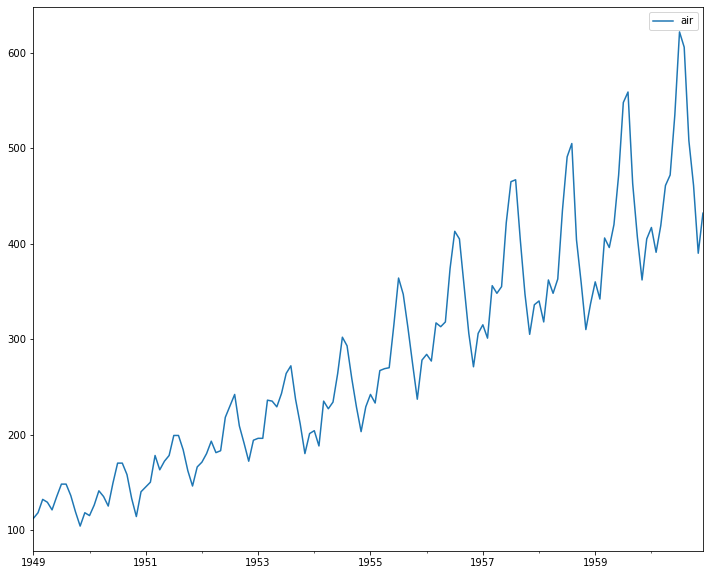

In [17]:
data2.plot(figsize = (12,10))

In [18]:
# No existen datos nulos
data2.isna().sum()

air    0
dtype: int64

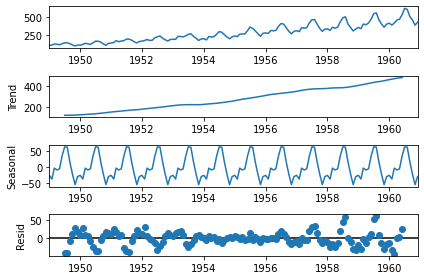

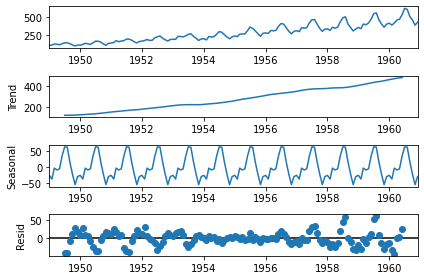

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data2, model="additive")
decompose_data.plot()

In [20]:
# Separación en train y test
train , test = train_test_split(data2, test_size = 0.2, shuffle = False)

In [21]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train))

In [22]:
# Prueba de estacionariedad
adf_test(train)

Results of Dickey-Fuller Test:
Test Statistic                  -0.356889
p-value                          0.917052
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
Non-stationary


In [23]:
diff1_values = train.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = train.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)


ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                  -2.539635
p-value                          0.106126
#Lags Used                      13.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -6.932644e+00
p-value                        1.074274e-09
#Lags Used                     1.300000e+01
Number of Observations Used    9.900000e+01
Critical Value (1%)           -3.498198e+00
Critical Value (5%)           -2.891208e+00
Critical Value (10%)          -2.582596e+00
dtype: float64
Stationary


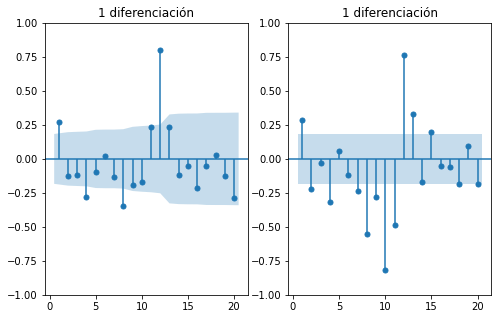

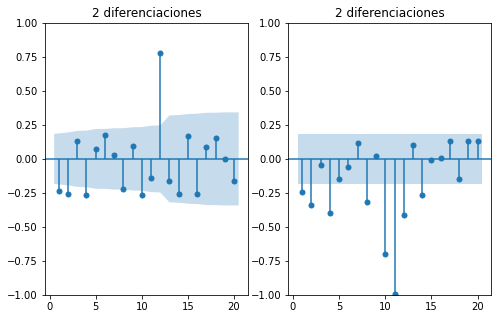

In [24]:

plot_acf_pacf(diff1_values, {'lags':20, 'title': '1 diferenciación'})

plot_acf_pacf(diff2_values, {'lags':20, 'title': '2 diferenciaciones'})


### Valores propuestos para el modelo:
 * Una diferenciación
    * p = 2
    * d = 1 
    * q = 1
* Dos diferenciaciones
    * p: 2
    * d: 2
    * q: 2

In [25]:
from statsmodels.tsa.arima.model import ARIMA



# 1. Modelo de diferencia de primer orden
arima_model1 = ARIMA(train, order=(2, 2, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  115
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 150.202
Date:                Tue, 07 Feb 2023   AIC                           -290.404
Time:                        16:42:54   BIC                           -276.768
Sample:                             0   HQIC                          -284.871
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5065      0.121     -4.193      0.000      -0.743      -0.270
ar.L2          0.0935      0.099      0.946      0.344      -0.100       0.287
ma.L1         -0.0481      0.345     -0.139      0.8

<AxesSubplot: >

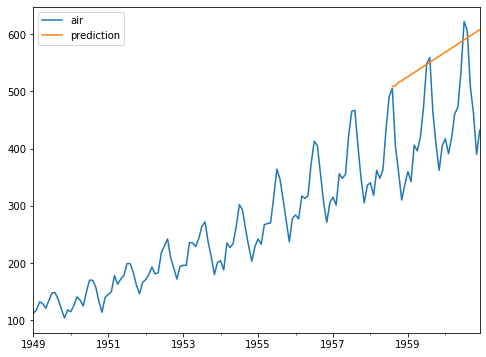

In [26]:
y_h = pd.DataFrame(scaler.inverse_transform(model1.predict(start = 115, end = 143,
                                                            dynamic=False).to_frame()),
                   
                  columns = ['prediction'], index = test.index)


ax = data2.plot(figsize = (8,6))

y_h.plot(ax=ax)

In [27]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(train,order=(2, 2, 2), seasonal_order = (2,2,2,12))

results=model.fit()

C:\Users\omara\anaconda3\envs\py3913\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\omara\anaconda3\envs\py3913\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\omara\anaconda3\envs\py3913\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  0   No. Observations:                  115
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood                 193.368
Date:                            Tue, 07 Feb 2023   AIC                           -368.735
Time:                                    16:42:59   BIC                           -346.337
Sample:                                         0   HQIC                          -359.707
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9832      1.264     -0.778      0.437      -3.460       1.494
ar.L2         -0.1736      0.465     -0.373      0.709      -1.085       0.738
ma.L1         -0.2883      1.251     -0.230      0.818      -2.740       2.164
ma.L2         -0.6694      1.167     -0.574      0.566      -2.956       1.617
ar.S.L12      -0.8607      1.555     -0.553      0.580      -3.909       2.188
ar.S.L24      -0.2147      0.366     -0.587      0.557      -0.932       0.503
ma.S.L12      -0.3657      1.513     -0.242      0.809      -3.331       2.600
ma.S.L24      -0.5271      1.870     -0.282      0.778      -4.192       3.138
sigma2         0.0005      0.000      1.056      0.291      -0.000       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.98   Prob(JB):                         0.51
Heteroskedasticity (H):               0.53   Skew:                             0.28
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: >

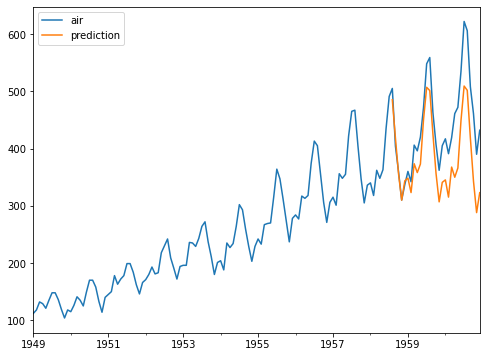

In [29]:
y_h = pd.DataFrame(scaler.inverse_transform(results.predict(start = 115, end = 143,
                                                            dynamic=False).to_frame()),
                   
                  columns = ['prediction'], index = test.index)


ax = data2.plot(figsize = (8,6))

y_h.plot(ax=ax)

### Forecast

In [30]:
from pandas.tseries.offsets import DateOffset
pred_date=[data2.index[-1] + DateOffset(months=x)for x in range(0,21)]

In [31]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data2.columns)
pred_date

,air
1961-01-01,NaN
1961-02-01,NaN
1961-03-01,NaN
1961-04-01,NaN
1961-05-01,NaN
1961-06-01,NaN
1961-07-01,NaN
1961-08-01,NaN
1961-09-01,NaN
1961-10-01,NaN


In [32]:
data=pd.concat([data2,pred_date])
data

,air
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1962-04-01,NaN
1962-05-01,NaN
1962-06-01,NaN
1962-07-01,NaN


In [33]:
y_h = pd.DataFrame(scaler.inverse_transform(model1.predict(start = 144, end = 163,
                                                            dynamic=False).to_frame()),
                   
                  columns = ['prediction'])

In [34]:
start = 144
h = data.index.to_numpy()

for i in range(y_h.shape[0]):
    j = i + start
    data.loc[h[j], 'forecast_ARIMA'] = y_h.loc[i, 'prediction']

In [40]:
y_h = pd.DataFrame(scaler.inverse_transform(results.predict(start = 144, end = 163,
                                                            dynamic=False).to_frame()),
                  columns = ['prediction'])
                   



In [41]:
start = 144
h = data.index.to_numpy()

for i in range(y_h.shape[0]):
    j = i + start
    data.loc[h[j], 'forecast_SARIMAX'] = y_h.loc[i, 'prediction']

In [42]:
data

,air,forecast_ARIMA,forecast_SARIMAX
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
...,...,...,...
1962-04-01,NaN,664.706225,281.404139
1962-05-01,NaN,668.270882,299.405039
1962-06-01,NaN,671.835538,392.570571
1962-07-01,NaN,675.400195,458.158378


<AxesSubplot: >

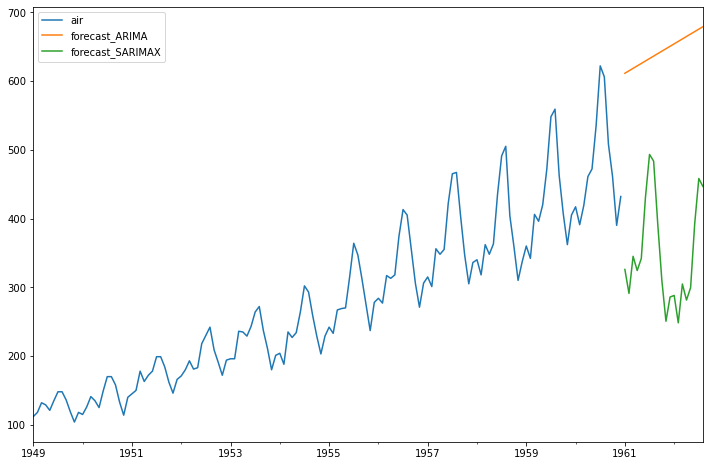

In [43]:
data[['air', 'forecast_ARIMA', 'forecast_SARIMAX']].plot(figsize=(12, 8))